* Name:Shubham Sahu
* Roll Number:12041430
* References Used to Complete the Assignment
    * a.
    * b. 
    * c. 

...


#0
# DATA importing and cleaning


In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle.json': b'{"username":"imsubhm","key":"e56ae5c832ea2b1bfd810c033e449f74"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions doywnload -c new-york-city-taxi-fare-prediction
!unzip new-york-city-taxi-fare-prediction

mkdir: cannot create directory ‘/root/.kaggle’: File exists
usage: kaggle competitions [-h]
                           {list,files,download,submit,submissions,leaderboard}
                           ...
kaggle competitions: error: argument command: invalid choice: 'doywnload' (choose from 'list', 'files', 'download', 'submit', 'submissions', 'leaderboard')
Archive:  new-york-city-taxi-fare-prediction.zip
replace GCP-Coupons-Instructions.rtf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: GCP-Coupons-Instructions.rtf  
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
import numpy as np 
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
import io
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import scipy.stats as st
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
from keras_tuner.tuners import RandomSearch

In [ ]:
train = pd.read_csv("/content/train.csv", nrows = 1000000)
test = pd.read_csv("/content/test.csv")

In [ ]:
#drop the missing values
train.dropna(axis=0, subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
train = train.reset_index(drop=True)

In [ ]:
train = train.drop(train[train['passenger_count']<=0].index, axis=0)
train = train.drop(train[train['passenger_count']>=7].index, axis=0)

In [ ]:
train = train.drop(train[train['pickup_latitude']<-90].index, axis=0)
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)

train = train.drop(train[train['dropoff_latitude']<-90].index, axis=0)
train = train.drop(train[train['dropoff_latitude']>90].index, axis=0)

In [ ]:
train = train.drop(train[train['pickup_longitude']<-180].index, axis=0)
train = train.drop(train[train['pickup_longitude']>180].index, axis=0)

train = train.drop(train[train['dropoff_longitude']<-180].index, axis=0)
train = train.drop(train[train['dropoff_longitude']>180].index, axis=0)

In [ ]:
test = test.drop(test[test['pickup_latitude']<-90].index, axis=0)
test = test.drop(test[test['pickup_latitude']>90].index, axis=0)

test = test.drop(test[test['dropoff_latitude']<-90].index, axis=0)
test = test.drop(test[test['dropoff_latitude']>90].index, axis=0)

In [ ]:
test = test.drop(test[test['pickup_longitude']<-180].index, axis=0)
test = test.drop(test[test['pickup_longitude']>180].index, axis=0)

test = test.drop(test[test['dropoff_longitude']<-180].index, axis=0)
test = test.drop(test[test['dropoff_longitude']>180].index, axis=0)

In [ ]:
train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

In [ ]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
#Convert for test data
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [ ]:
def select_outside_boundingbox(df, BB):
    filter_df = df.loc[(df['pickup_longitude'] < BB[0]) | (df['pickup_longitude'] > BB[1]) | \
           (df['pickup_latitude'] < BB[2]) | (df['pickup_latitude'] > BB[3]) | \
           (df['dropoff_longitude'] < BB[0]) | (df['dropoff_longitude'] > BB[1]) | \
           (df['dropoff_latitude'] < BB[2]) | (df['dropoff_latitude'] > BB[3])]
    return filter_df

NYC_BB = (-74.5, -72.8, 40.5, 41.8)

In [ ]:
train_outliers = select_outside_boundingbox(train, NYC_BB)
train_outliers

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,2012-12-24 11:24:00.000000980,5.5,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1
124,2013-01-17 17:22:00.000000430,8.0,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2
192,2010-09-05 17:08:00.000000920,3.7,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...
999703,2013-06-07 20:40:21.000000300,8.0,2013-06-07 20:40:21+00:00,0.0,0.0,0.0,0.0,2
999713,2013-03-03 13:18:00.000000227,3.5,2013-03-03 13:18:00+00:00,0.0,0.0,0.0,0.0,6
999721,2014-05-04 23:27:00.000000103,9.0,2014-05-04 23:27:00+00:00,0.0,0.0,0.0,0.0,6
999878,2010-04-28 21:08:00.000000380,9.3,2010-04-28 21:08:00+00:00,0.0,0.0,0.0,0.0,3


In [ ]:
train = train.drop(train_outliers.index, axis=0)

In [ ]:
test_outliers = select_outside_boundingbox(test, NYC_BB)
test_outliers

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [ ]:
data = [train,test]

for i in data:
    i["hour"] = i.pickup_datetime.dt.hour
    i["day_of_week"] = i.pickup_datetime.dt.weekday
    i["day_of_month"] = i.pickup_datetime.dt.day
    i["week"] = i.pickup_datetime.dt.isocalendar().week
    i["month"] = i.pickup_datetime.dt.month
    i["year"] = i.pickup_datetime.dt.year

In [ ]:
# Calculating the Distance between the pickup and dropoff locations
data = [train, test]
for i in data:
    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(i['pickup_latitude'])
    phi2 = np.radians(i['dropoff_latitude'])

    delta_phi = np.radians(i['dropoff_latitude']-i['pickup_latitude'])
    delta_lambda = np.radians(i['dropoff_longitude']-i['pickup_longitude'])

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    i['H_Distance'] = d

In [ ]:
# Lets filter the rows where both distance and fare are available
filtered = train[(train['H_Distance'] > 0) & (train['fare_amount'] > 0)]
# We need a column with fare_amount / H_Distance
Average_Fare_Per_Km = (filtered['fare_amount'] / filtered['H_Distance']).mean()

In [ ]:
Average_Fare_Per_Km

87.11394133206247

In [ ]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year,H_Distance
count,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000,975570.000000
mean,11.338099,-73.975088,40.751112,-73.974206,40.751450,1.691039,13.509106,3.039572,15.692332,25.470487,6.270817,2011.740062,3.329588
std,9.725364,0.038576,0.029581,0.037753,0.032758,1.306167,6.511945,1.949821,8.682332,14.952007,3.437410,1.866355,3.765211
min,-44.900000,-74.481853,40.500046,-74.475731,40.500046,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992269,40.736580,-73.991570,40.735592,1.000000,9.000000,1.000000,8.000000,13.000000,3.000000,2010.000000,1.253996
50%,8.500000,-73.982082,40.753413,-73.980590,40.753875,1.000000,14.000000,3.000000,16.000000,24.000000,6.000000,2012.000000,2.153130
75%,12.500000,-73.968311,40.767580,-73.965316,40.768419,2.000000,19.000000,5.000000,23.000000,39.000000,9.000000,2013.000000,3.918668
max,500.000000,-72.856968,41.696852,-72.848088,41.714633,6.000000,23.000000,6.000000,31.000000,53.000000,12.000000,2015.000000,110.833077


In [ ]:
scaler = StandardScaler()
model = scaler.fit(train.drop(['key', 'pickup_datetime', 'fare_amount'], axis=1))
scaled_data = model.transform(train.drop(['key', 'pickup_datetime', 'fare_amount'], axis=1))

In [ ]:
train.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year,H_Distance
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,15,25,6,2009,1.030764
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,5,1,1,2010,8.450134
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,18,33,8,2011,1.389525
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,21,16,4,2012,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,9,10,3,2010,1.999157


In [ ]:
scalery = StandardScaler()
yhat = scalery.fit(train[['fare_amount']])
scaled_y = yhat.transform(train[['fare_amount']])

In [ ]:
scaled_data.shape

(975570, 12)

In [ ]:
scaled_y.shape

(975570, 1)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, scaled_y, random_state=25)

#1
#Creating a baseline Neural network

In [ ]:
model1 = tf.keras.Sequential(name='Q1_model1')
model1.add(tf.keras.layers.Dense(12, input_shape=(12,)))
model1.add(tf.keras.layers.Dense(16, activation='sigmoid', kernel_initializer='normal'))
model1.add(tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='normal'))
model1.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
model1.summary()

Model: "Q1_model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 12)                156       
                                                                 
 dense_21 (Dense)            (None, 16)                208       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 509
Trainable params: 509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer='adam',
    loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'])

In [ ]:
history = model1.fit(xtrain, ytrain, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
4573/4573 [==============================] - 10s 2ms/step - loss: 0.5272 - mean_absolute_error: 0.5272 - mean_squared_error: 0.9934 - mean_absolute_percentage_error: 198.2472 - val_loss: 0.4016 - val_mean_absolute_error: 0.4016 - val_mean_squared_error: 0.7064 - val_mean_absolute_percentage_error: 153.4961
Epoch 2/50
4573/4573 [==============================] - 9s 2ms/step - loss: 0.2765 - mean_absolute_error: 0.2765 - mean_squared_error: 0.3799 - mean_absolute_percentage_error: 151.5374 - val_loss: 0.2496 - val_mean_absolute_error: 0.2496 - val_mean_squared_error: 0.3721 - val_mean_absolute_percentage_error: 147.8802
Epoch 3/50
4573/4573 [==============================] - 9s 2ms/step - loss: 0.2408 - mean_absolute_error: 0.2408 - mean_squared_error: 0.2816 - mean_absolute_percentage_error: 146.8225 - val_loss: 0.2360 - val_mean_absolute_error: 0.2360 - val_mean_squared_error: 0.3313 - val_mean_absolute_percentage_error: 144.3220
Epoch 4/50
4573/4573 [=======================

TO calculate losses of our model on validation data.

In [ ]:
def calculate_error(model, y):
    predictions = model.predict(xtest)
    m1 = mean_absolute_error(y, predictions)
    m2 = mean_squared_error(y, predictions)
    m3 = mean_absolute_percentage_error(y, predictions)
    print('Mean Absolute error', m1, '\n', 'Mean Squared error', m2, '\n', 'Mean absolute percentage error', m3)
    return m1, m2, m3

In [ ]:
calculate_error(model1, ytest)

Mean Absolute error 0.19787550469086643 
 Mean Squared error 0.22089817637968714 
 Mean absolute percentage error 1.2501084107646627


(0.19787550469086643, 0.22089817637968714, 1.2501084107646627)

To plot loss against number of epochs:

In [ ]:
def plot_loss(model):
    print(model.history.keys())
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_mean_absolute_percentage_error'])


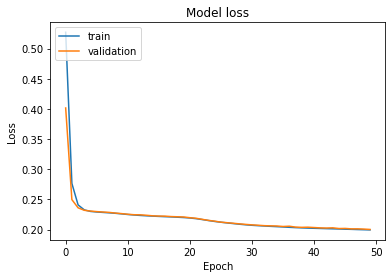

In [ ]:
plot_loss(history)

#playing with activation functions

Using RELU

In [ ]:
model2 = tf.keras.Sequential(name='model2')
model2.add(tf.keras.layers.Dense(12, input_shape=(12,)))
model2.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='normal'))
model2.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='normal'))
model2.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
model2.add(tf.keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
model2.add(tf.keras.layers.Dense(1, activation='linear'))

model2.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 12)                156       
                                                                 
 dense_25 (Dense)            (None, 64)                832       
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable pa

In [ ]:
model2.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer='adam', metrics=[tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanSquaredError()])

In [ ]:
history2 = model2.fit(xtrain, ytrain, epochs=50, batch_size=128, validation_split=0.3)

Epoch 1/50
4002/4002 [==============================] - 18s 4ms/step - loss: 87.8691 - mean_absolute_percentage_error: 87.8735 - mean_absolute_error: 0.4699 - mean_squared_error: 0.7990 - val_loss: 78.7879 - val_mean_absolute_percentage_error: 78.7867 - val_mean_absolute_error: 0.3228 - val_mean_squared_error: 0.4204
Epoch 2/50
4002/4002 [==============================] - 14s 4ms/step - loss: 81.9452 - mean_absolute_percentage_error: 81.9417 - mean_absolute_error: 0.3563 - mean_squared_error: 0.4787 - val_loss: 76.7309 - val_mean_absolute_percentage_error: 76.7297 - val_mean_absolute_error: 0.3232 - val_mean_squared_error: 0.3991
Epoch 3/50
4002/4002 [==============================] - 13s 3ms/step - loss: 79.4694 - mean_absolute_percentage_error: 79.4662 - mean_absolute_error: 0.3506 - mean_squared_error: 0.4939 - val_loss: 75.8216 - val_mean_absolute_percentage_error: 75.8202 - val_mean_absolute_error: 0.3207 - val_mean_squared_error: 0.4309
Epoch 4/50
4002/4002 [=====================

In [ ]:
calculate_error(model2, ytest)

Mean Absolute error 0.24280169226166468 
 Mean Squared error 0.26813146089962614 
 Mean absolute percentage error 0.6670424634433358


(0.24280169226166468, 0.26813146089962614, 0.6670424634433358)

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'val_mean_squared_error'])


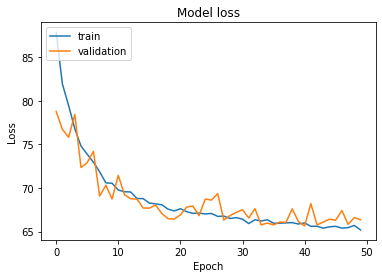

In [ ]:
plot_loss(history2)

sigmoid function with same model as model2

In [ ]:
model3 = tf.keras.Sequential(name='Q1_model3')
model3.add(tf.keras.layers.Dense(12, input_shape=(12,)))
model3.add(tf.keras.layers.Dense(64, activation='sigmoid', kernel_initializer='normal'))
model3.add(tf.keras.layers.Dense(32, activation='sigmoid', kernel_initializer='normal'))
model3.add(tf.keras.layers.Dense(16, activation='sigmoid', kernel_initializer='normal'))
model3.add(tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='normal'))
model3.add(tf.keras.layers.Dense(1, activation='linear'))

model3.summary()

Model: "Q1_model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 12)                156       
                                                                 
 dense_41 (Dense)            (None, 64)                832       
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dense_44 (Dense)            (None, 8)                 136       
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable

In [ ]:
model3.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer='adam', metrics=[tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanSquaredError()])

In [ ]:
history3 = model3.fit(xtrain, ytrain, batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
4573/4573 [==============================] - 14s 3ms/step - loss: 102.9653 - mean_absolute_percentage_error: 102.9652 - mean_absolute_error: 0.5871 - mean_squared_error: 0.9575 - val_loss: 93.3452 - val_mean_absolute_percentage_error: 93.3368 - val_mean_absolute_error: 0.5238 - val_mean_squared_error: 0.9761
Epoch 2/40
4573/4573 [==============================] - 13s 3ms/step - loss: 88.0968 - mean_absolute_percentage_error: 88.0971 - mean_absolute_error: 0.4820 - mean_squared_error: 0.8862 - val_loss: 87.6078 - val_mean_absolute_percentage_error: 87.5991 - val_mean_absolute_error: 0.4594 - val_mean_squared_error: 0.9397
Epoch 3/40
4573/4573 [==============================] - 14s 3ms/step - loss: 86.5439 - mean_absolute_percentage_error: 86.5439 - mean_absolute_error: 0.4616 - mean_squared_error: 0.8720 - val_loss: 86.9900 - val_mean_absolute_percentage_error: 86.9807 - val_mean_absolute_error: 0.4537 - val_mean_squared_error: 0.9308
Epoch 4/40
4573/4573 [===================

In [ ]:
calculate_error(model3, ytest)

Mean Absolute error 0.4365860454853809 
 Mean Squared error 0.849134531571921 
 Mean absolute percentage error 0.7843303547269888


(0.4365860454853809, 0.849134531571921, 0.7843303547269888)

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'val_mean_squared_error'])


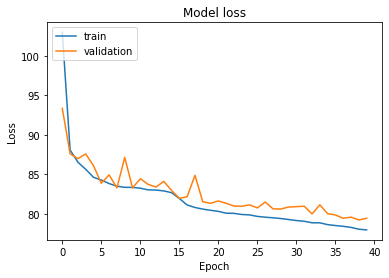

In [ ]:
plot_loss(history3)

In [ ]:
model4 = tf.keras.Sequential(name='model4')
model4.add(tf.keras.layers.Dense(12, input_shape=(12,)))
model4.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
model4.add(tf.keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
model4.add(tf.keras.layers.Dense(1, activation='linear'))

model4.summary()

Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 12)                156       
                                                                 
 dense_37 (Dense)            (None, 16)                208       
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 509
Trainable params: 509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer='adam', metrics=[tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.losses.MeanAbsoluteError()])

In [ ]:
history4 = model4.fit(xtrain, ytrain, epochs=40, batch_size=128, validation_split=0.2)

Epoch 1/40
4573/4573 [==============================] - 13s 3ms/step - loss: 85.8913 - mean_absolute_percentage_error: 85.8912 - mean_absolute_error: 0.4084 - val_loss: 79.3231 - val_mean_absolute_percentage_error: 79.3137 - val_mean_absolute_error: 0.3040
Epoch 2/40
4573/4573 [==============================] - 10s 2ms/step - loss: 82.4916 - mean_absolute_percentage_error: 82.4916 - mean_absolute_error: 0.3344 - val_loss: 78.8359 - val_mean_absolute_percentage_error: 78.8299 - val_mean_absolute_error: 0.3203
Epoch 3/40
4573/4573 [==============================] - 10s 2ms/step - loss: 81.0679 - mean_absolute_percentage_error: 81.0678 - mean_absolute_error: 0.3295 - val_loss: 77.2950 - val_mean_absolute_percentage_error: 77.2901 - val_mean_absolute_error: 0.3200
Epoch 4/40
4573/4573 [==============================] - 11s 2ms/step - loss: 79.3733 - mean_absolute_percentage_error: 79.3732 - mean_absolute_error: 0.3350 - val_loss: 77.1338 - val_mean_absolute_percentage_error: 77.1284 - val_

In [ ]:
calculate_error(model4, ytest)

Mean Absolute error 0.27282219108718375 
 Mean Squared error 0.30133283174848186 
 Mean absolute percentage error 0.7026147764006628


(0.27282219108718375, 0.30133283174848186, 0.7026147764006628)

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error'])


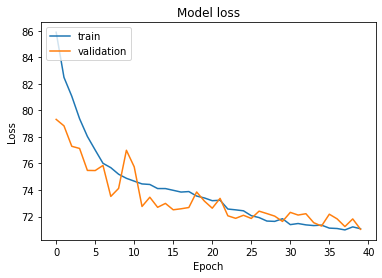

In [ ]:
plot_loss(history4)

from above 4 models it is visibel that RElu activation function is much better than sigmoid for given problem.

#tuning hyperparameters for neural networks

In [ ]:
def make_model(n_hidden=1, n_neurons=20, learning_rate=3e-3, input_shape=(12,)):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(12, input_shape=(12,)))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.Adam(lr=learning_rate)
  model.compile(loss=['mape'], optimizer=optimizer)
  return model


In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(make_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
param_distribs = {
"n_hidden": [1, 2, 3],
"n_neurons": [8,12,16,20],
"learning_rate": reciprocal(1e-4, 1e-2),
}
rnd = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,
cv=3)
rnd.fit(xtrain, ytrain, epochs=10,
validation_data=(xtest, ytest),
callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 38s 2ms/step - loss: 92.9514 - val_loss: 88.1718
Epoch 2/10
15244/15244 [==============================] - 43s 3ms/step - loss: 88.9569 - val_loss: 85.8251
Epoch 3/10
15244/15244 [==============================] - 39s 3ms/step - loss: 87.4013 - val_loss: 83.3984
Epoch 4/10
15244/15244 [==============================] - 36s 2ms/step - loss: 86.7986 - val_loss: 85.2653
Epoch 5/10
15244/15244 [==============================] - 49s 3ms/step - loss: 86.1137 - val_loss: 88.0109
Epoch 6/10
15244/15244 [==============================] - 60s 4ms/step - loss: 86.2950 - val_loss: 86.4367
Epoch 7/10
15244/15244 [==============================] - 51s 3ms/step - loss: 86.3165 - val_loss: 85.3184
Epoch 8/10
15244/15244 [==============================] - 42s 3ms/step - loss: 86.4495 - val_loss: 86.4788
Epoch 9/10
15244/15244 [==============================] - 51s 3ms/step - loss: 86.5972 - val_loss: 87.4034
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 36s 2ms/step - loss: 91.2158 - val_loss: 89.2963
Epoch 2/10
15244/15244 [==============================] - 38s 3ms/step - loss: 88.8993 - val_loss: 90.5888
Epoch 3/10
15244/15244 [==============================] - 39s 3ms/step - loss: 88.5029 - val_loss: 93.0935
Epoch 4/10
15244/15244 [==============================] - 48s 3ms/step - loss: 88.6099 - val_loss: 86.7451
Epoch 5/10
15244/15244 [==============================] - 44s 3ms/step - loss: 86.5615 - val_loss: 84.0866
Epoch 6/10
15244/15244 [==============================] - 58s 4ms/step - loss: 86.5507 - val_loss: 84.4052
Epoch 7/10
15244/15244 [==============================] - 38s 2ms/step - loss: 85.7154 - val_loss: 85.6629
Epoch 8/10
15244/15244 [==============================] - 38s 2ms/step - loss: 86.0031 - val_loss: 83.4967
Epoch 9/10
15244/15244 [==============================] - 39s 3ms/step - loss: 85.7916 - val_loss: 92.4055
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 53s 3ms/step - loss: 92.7315 - val_loss: 89.2960
Epoch 2/10
15244/15244 [==============================] - 57s 4ms/step - loss: 88.5427 - val_loss: 86.8774
Epoch 3/10
15244/15244 [==============================] - 57s 4ms/step - loss: 87.0939 - val_loss: 88.4954
Epoch 4/10
15244/15244 [==============================] - 56s 4ms/step - loss: 86.2521 - val_loss: 89.1322
Epoch 5/10
15244/15244 [==============================] - 45s 3ms/step - loss: 86.9242 - val_loss: 86.4047
Epoch 6/10
15244/15244 [==============================] - 38s 3ms/step - loss: 86.3749 - val_loss: 83.7777
Epoch 7/10
15244/15244 [==============================] - 37s 2ms/step - loss: 85.8605 - val_loss: 84.8943
Epoch 8/10
15244/15244 [==============================] - 38s 2ms/step - loss: 85.7930 - val_loss: 84.0005
Epoch 9/10
15244/15244 [==============================] - 40s 3ms/step - loss: 85.5721 - val_loss: 85.1328
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 52s 3ms/step - loss: 104.3638 - val_loss: 89.4750
Epoch 2/10
15244/15244 [==============================] - 54s 4ms/step - loss: 86.0425 - val_loss: 84.9520
Epoch 3/10
15244/15244 [==============================] - 53s 3ms/step - loss: 83.4194 - val_loss: 83.5203
Epoch 4/10
15244/15244 [==============================] - 44s 3ms/step - loss: 82.2423 - val_loss: 82.6964
Epoch 5/10
15244/15244 [==============================] - 48s 3ms/step - loss: 81.5299 - val_loss: 82.4512
Epoch 6/10
15244/15244 [==============================] - 47s 3ms/step - loss: 80.7916 - val_loss: 81.4526
Epoch 7/10
15244/15244 [==============================] - 42s 3ms/step - loss: 80.1141 - val_loss: 80.7661
Epoch 8/10
15244/15244 [==============================] - 46s 3ms/step - loss: 79.4058 - val_loss: 80.0839
Epoch 9/10
15244/15244 [==============================] - 44s 3ms/step - loss: 78.6921 - val_loss: 78.8936
Epoch 10/10
7622/7622 [========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 44s 3ms/step - loss: 101.8169 - val_loss: 96.8244
Epoch 2/10
15244/15244 [==============================] - 40s 3ms/step - loss: 91.7995 - val_loss: 88.7355
Epoch 3/10
15244/15244 [==============================] - 37s 2ms/step - loss: 84.7551 - val_loss: 85.2623
Epoch 4/10
15244/15244 [==============================] - 37s 2ms/step - loss: 81.8440 - val_loss: 82.9812
Epoch 5/10
15244/15244 [==============================] - 39s 3ms/step - loss: 80.6747 - val_loss: 82.0152
Epoch 6/10
15244/15244 [==============================] - 37s 2ms/step - loss: 79.9477 - val_loss: 81.7042
Epoch 7/10
15244/15244 [==============================] - 39s 3ms/step - loss: 79.4016 - val_loss: 81.3872
Epoch 8/10
15244/15244 [==============================] - 39s 3ms/step - loss: 79.1522 - val_loss: 80.9878
Epoch 9/10
15244/15244 [==============================] - 51s 3ms/step - loss: 78.8031 - val_loss: 81.0222
Epoch 10/10
7622/7622 [========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 38s 2ms/step - loss: 103.9856 - val_loss: 95.0052
Epoch 2/10
15244/15244 [==============================] - 37s 2ms/step - loss: 90.7232 - val_loss: 88.1672
Epoch 3/10
15244/15244 [==============================] - 35s 2ms/step - loss: 87.7661 - val_loss: 86.9491
Epoch 4/10
15244/15244 [==============================] - 38s 2ms/step - loss: 86.5050 - val_loss: 85.7792
Epoch 5/10
15244/15244 [==============================] - 39s 3ms/step - loss: 86.0816 - val_loss: 85.3123
Epoch 6/10
15244/15244 [==============================] - 37s 2ms/step - loss: 85.5045 - val_loss: 84.6404
Epoch 7/10
15244/15244 [==============================] - 36s 2ms/step - loss: 84.6450 - val_loss: 83.9165
Epoch 8/10
15244/15244 [==============================] - 37s 2ms/step - loss: 83.9792 - val_loss: 82.6947
Epoch 9/10
15244/15244 [==============================] - 40s 3ms/step - loss: 83.1135 - val_loss: 82.0715
Epoch 10/10
7622/7622 [========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 42s 3ms/step - loss: 88.0406 - val_loss: 83.0250
Epoch 2/10
15244/15244 [==============================] - 39s 3ms/step - loss: 80.6687 - val_loss: 80.8227
Epoch 3/10
15244/15244 [==============================] - 42s 3ms/step - loss: 80.7941 - val_loss: 78.4904
Epoch 4/10
15244/15244 [==============================] - 39s 3ms/step - loss: 78.4992 - val_loss: 79.4073
Epoch 5/10
15244/15244 [==============================] - 39s 3ms/step - loss: 77.1694 - val_loss: 76.6369
Epoch 6/10
15244/15244 [==============================] - 39s 3ms/step - loss: 76.7885 - val_loss: 77.0913
Epoch 7/10
15244/15244 [==============================] - 41s 3ms/step - loss: 75.3007 - val_loss: 73.9630
Epoch 8/10
15244/15244 [==============================] - 41s 3ms/step - loss: 75.3101 - val_loss: 75.6014
Epoch 9/10
15244/15244 [==============================] - 42s 3ms/step - loss: 74.9658 - val_loss: 74.3551
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 41s 3ms/step - loss: 86.1236 - val_loss: 82.4967
Epoch 2/10
15244/15244 [==============================] - 40s 3ms/step - loss: 80.6575 - val_loss: 80.3831
Epoch 3/10
15244/15244 [==============================] - 42s 3ms/step - loss: 78.3689 - val_loss: 80.1457
Epoch 4/10
15244/15244 [==============================] - 44s 3ms/step - loss: 77.2712 - val_loss: 76.9050
Epoch 5/10
15244/15244 [==============================] - 47s 3ms/step - loss: 76.6463 - val_loss: 77.1951
Epoch 6/10
15244/15244 [==============================] - 42s 3ms/step - loss: 76.2697 - val_loss: 76.6943
Epoch 7/10
15244/15244 [==============================] - 42s 3ms/step - loss: 75.9935 - val_loss: 76.3735
Epoch 8/10
15244/15244 [==============================] - 39s 3ms/step - loss: 74.9392 - val_loss: 74.3064
Epoch 9/10
15244/15244 [==============================] - 41s 3ms/step - loss: 74.4666 - val_loss: 73.7383
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 42s 3ms/step - loss: 90.2162 - val_loss: 86.1272
Epoch 2/10
15244/15244 [==============================] - 41s 3ms/step - loss: 82.5791 - val_loss: 80.8084
Epoch 3/10
15244/15244 [==============================] - 41s 3ms/step - loss: 80.6616 - val_loss: 79.4800
Epoch 4/10
15244/15244 [==============================] - 41s 3ms/step - loss: 79.5894 - val_loss: 79.1847
Epoch 5/10
15244/15244 [==============================] - 42s 3ms/step - loss: 78.7097 - val_loss: 76.8953
Epoch 6/10
15244/15244 [==============================] - 42s 3ms/step - loss: 77.9045 - val_loss: 76.8620
Epoch 7/10
15244/15244 [==============================] - 41s 3ms/step - loss: 77.9425 - val_loss: 76.3994
Epoch 8/10
15244/15244 [==============================] - 42s 3ms/step - loss: 77.1505 - val_loss: 74.5361
Epoch 9/10
15244/15244 [==============================] - 41s 3ms/step - loss: 76.5045 - val_loss: 75.4632
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 40s 3ms/step - loss: 98.1376 - val_loss: 87.9721
Epoch 2/10
15244/15244 [==============================] - 40s 3ms/step - loss: 84.8772 - val_loss: 84.1014
Epoch 3/10
15244/15244 [==============================] - 40s 3ms/step - loss: 81.5682 - val_loss: 82.2951
Epoch 4/10
15244/15244 [==============================] - 40s 3ms/step - loss: 79.8073 - val_loss: 80.2151
Epoch 5/10
15244/15244 [==============================] - 39s 3ms/step - loss: 78.4367 - val_loss: 77.9515
Epoch 6/10
15244/15244 [==============================] - 40s 3ms/step - loss: 76.1741 - val_loss: 76.0181
Epoch 7/10
15244/15244 [==============================] - 42s 3ms/step - loss: 74.2011 - val_loss: 74.7302
Epoch 8/10
15244/15244 [==============================] - 43s 3ms/step - loss: 73.4181 - val_loss: 73.5622
Epoch 9/10
15244/15244 [==============================] - 40s 3ms/step - loss: 72.7475 - val_loss: 72.6689
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 43s 3ms/step - loss: 94.7668 - val_loss: 85.8192
Epoch 2/10
15244/15244 [==============================] - 43s 3ms/step - loss: 82.9686 - val_loss: 83.5004
Epoch 3/10
15244/15244 [==============================] - 40s 3ms/step - loss: 81.0633 - val_loss: 81.7813
Epoch 4/10
15244/15244 [==============================] - 42s 3ms/step - loss: 79.6038 - val_loss: 81.2688
Epoch 5/10
15244/15244 [==============================] - 41s 3ms/step - loss: 78.4357 - val_loss: 78.6972
Epoch 6/10
15244/15244 [==============================] - 41s 3ms/step - loss: 76.9340 - val_loss: 78.5509
Epoch 7/10
15244/15244 [==============================] - 42s 3ms/step - loss: 75.8413 - val_loss: 76.0005
Epoch 8/10
15244/15244 [==============================] - 40s 3ms/step - loss: 74.9367 - val_loss: 75.1511
Epoch 9/10
15244/15244 [==============================] - 42s 3ms/step - loss: 73.8543 - val_loss: 74.8279
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 43s 3ms/step - loss: 98.3155 - val_loss: 89.3597
Epoch 2/10
15244/15244 [==============================] - 41s 3ms/step - loss: 87.3135 - val_loss: 83.3439
Epoch 3/10
15244/15244 [==============================] - 43s 3ms/step - loss: 83.1271 - val_loss: 81.1265
Epoch 4/10
15244/15244 [==============================] - 43s 3ms/step - loss: 80.6959 - val_loss: 79.0670
Epoch 5/10
15244/15244 [==============================] - 40s 3ms/step - loss: 79.1397 - val_loss: 78.9043
Epoch 6/10
15244/15244 [==============================] - 40s 3ms/step - loss: 78.3253 - val_loss: 78.4723
Epoch 7/10
15244/15244 [==============================] - 42s 3ms/step - loss: 77.4395 - val_loss: 76.8842
Epoch 8/10
15244/15244 [==============================] - 42s 3ms/step - loss: 76.2944 - val_loss: 75.3467
Epoch 9/10
15244/15244 [==============================] - 45s 3ms/step - loss: 75.4366 - val_loss: 74.1027
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 40s 3ms/step - loss: 92.8359 - val_loss: 85.2738
Epoch 2/10
15244/15244 [==============================] - 38s 2ms/step - loss: 81.6953 - val_loss: 79.4233
Epoch 3/10
15244/15244 [==============================] - 39s 3ms/step - loss: 80.6757 - val_loss: 83.0933
Epoch 4/10
15244/15244 [==============================] - 38s 2ms/step - loss: 80.5246 - val_loss: 80.1818
Epoch 5/10
15244/15244 [==============================] - 40s 3ms/step - loss: 79.7613 - val_loss: 79.9862
Epoch 6/10
15244/15244 [==============================] - 38s 2ms/step - loss: 80.1086 - val_loss: 79.4816
Epoch 7/10
15244/15244 [==============================] - 40s 3ms/step - loss: 79.5884 - val_loss: 79.6100
Epoch 8/10
15244/15244 [==============================] - 38s 2ms/step - loss: 79.7387 - val_loss: 79.7054
Epoch 9/10
15244/15244 [==============================] - 40s 3ms/step - loss: 79.6450 - val_loss: 82.5326
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15244/15244 [==============================] - 38s 2ms/step - loss: 94.0862 - val_loss: 85.5234
Epoch 2/10
15244/15244 [==============================] - 38s 2ms/step - loss: 81.9403 - val_loss: 81.6220
Epoch 3/10
15244/15244 [==============================] - 38s 2ms/step - loss: 81.0792 - val_loss: 83.0132
Epoch 4/10
15244/15244 [==============================] - 38s 3ms/step - loss: 80.2497 - val_loss: 79.1774
Epoch 5/10
15244/15244 [==============================] - 38s 2ms/step - loss: 79.7358 - val_loss: 85.7863
Epoch 6/10
15244/15244 [==============================] - 38s 3ms/step - loss: 78.7215 - val_loss: 78.3443
Epoch 7/10
15244/15244 [==============================] - 39s 3ms/step - loss: 78.7928 - val_loss: 78.0991
Epoch 8/10
15244/15244 [==============================] - 39s 3ms/step - loss: 78.8739 - val_loss: 87.2037
Epoch 9/10
15244/15244 [==============================] - 39s 3ms/step - loss: 78.9321 - val_loss: 85.7794
Epoch 10/10
7622/7622 [=========================

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13904/15244 [==========================>...] - ETA: 2s - loss: 95.7009

KeyboardInterrupt: ignored

In [ ]:
rnd.best_params_

In [ ]:
model = rnd.best_estimator_.model

In [ ]:
model.summary()

In [ ]:
calculate_error(model, ytest)

#early stopping


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, mode='max')
#mointor->it continuously monitors validation loss and stops when reqired
#patience->stops training when there is no improvement seen
#min_delta->minimum change required to call it improvement

In [ ]:
history5 = model.fit(xtrain, ytrain, epochs=50, batch_size=128, validation_split=0.25, callbacks=[early])

In [ ]:
calculate_error(model, ytest)

In [ ]:
plot_loss(history5)

#using dropout

In [ ]:
model6 = tf.keras.Sequential(name='Q1_model6')
model6.add(keras.layers.Dense(12, input_shape=(12,)))
model6.add(keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
model6.add(keras.layers.Dropout(0.5))
model6.add(keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
model6.add(keras.layers.Dropout(0.2))
model6.add(keras.layers.Dense(1, activation='linear'))

model6.compile(loss=['mape'], optimizer=keras.optimizers.Adam(lr=0.001))
history6 = model6.fit(xtrain, ytrain, validation_split=0.25, epochs=50, batch_size=128)

Epoch 1/50
4288/4288 [==============================] - 11s 2ms/step - loss: 91.5282 - val_loss: 86.2697
Epoch 2/50
4288/4288 [==============================] - 19s 4ms/step - loss: 89.4255 - val_loss: 84.5989
Epoch 3/50
4288/4288 [==============================] - 13s 3ms/step - loss: 89.3306 - val_loss: 83.2348
Epoch 4/50
4288/4288 [==============================] - 14s 3ms/step - loss: 87.3921 - val_loss: 84.9303
Epoch 5/50
4288/4288 [==============================] - 11s 3ms/step - loss: 87.5682 - val_loss: 84.8415
Epoch 6/50
4288/4288 [==============================] - 12s 3ms/step - loss: 87.4874 - val_loss: 83.7514
Epoch 7/50
4288/4288 [==============================] - 11s 3ms/step - loss: 88.2767 - val_loss: 82.8442
Epoch 8/50
4288/4288 [==============================] - 12s 3ms/step - loss: 87.2075 - val_loss: 83.0003
Epoch 9/50
4288/4288 [==============================] - 12s 3ms/step - loss: 89.0610 - val_loss: 83.5153
Epoch 10/50
4288/4288 [==============================] 

In [ ]:
calculate_error(model6, ytest)

Mean Absolute error 0.44336265450905726 
 Mean Squared error 0.5415367910215334 
 Mean absolute percentage error 0.872625766512887


(0.44336265450905726, 0.5415367910215334, 0.872625766512887)

dict_keys(['loss', 'val_loss'])


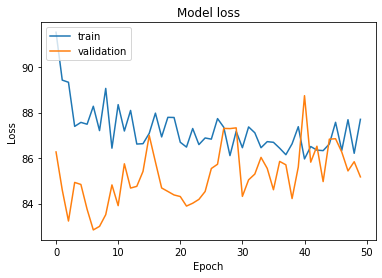

In [ ]:
plot_loss(history6)

In [ ]:
model7 = tf.keras.Sequential(name='Q1_model6')
model7.add(keras.layers.Dense(12, input_shape=(12,), kernel_initializer='normal'))
model7.add(keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
model7.add(keras.layers.Dropout(0.2))
model7.add(keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
model7.add(keras.layers.Dropout(0.1))
model7.add(keras.layers.Dense(1, activation='linear'))

model7.compile(loss=['mape'], optimizer=keras.optimizers.Adam(lr=0.001))
history7 = model7.fit(xtrain, ytrain, validation_split=0.25, epochs=100, batch_size=128)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4288/4288 [==============================] - 12s 3ms/step - loss: 88.8898 - val_loss: 83.1025
Epoch 2/100
4288/4288 [==============================] - 10s 2ms/step - loss: 87.1583 - val_loss: 85.8937
Epoch 3/100
4288/4288 [==============================] - 10s 2ms/step - loss: 87.4798 - val_loss: 82.8901
Epoch 4/100
4288/4288 [==============================] - 10s 2ms/step - loss: 86.6423 - val_loss: 82.3583
Epoch 5/100
4288/4288 [==============================] - 11s 3ms/step - loss: 86.3102 - val_loss: 81.8566
Epoch 6/100
4288/4288 [==============================] - 10s 2ms/step - loss: 85.5871 - val_loss: 81.1968
Epoch 7/100
4288/4288 [==============================] - 11s 3ms/step - loss: 85.6241 - val_loss: 80.7470
Epoch 8/100
4288/4288 [==============================] - 11s 3ms/step - loss: 85.4541 - val_loss: 82.0088
Epoch 9/100
4288/4288 [==============================] - 10s 2ms/step - loss: 84.7713 - val_loss: 80.6250
Epoch 10/100
4288/4288 [==============================] - 

In [ ]:
calculate_error(model7, ytest)

Mean Absolute error 0.39868579787593056 
 Mean Squared error 0.5783593209313536 
 Mean absolute percentage error 0.8048689301402403


(0.39868579787593056, 0.5783593209313536, 0.8048689301402403)

dict_keys(['loss', 'val_loss'])


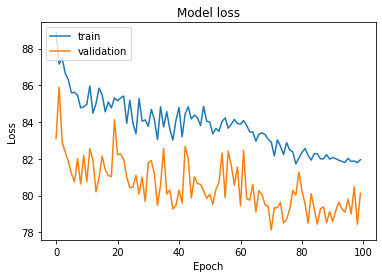

In [ ]:
plot_loss(history7)

#more optimizers:

1.RMSprop

In [ ]:
model8 = tf.keras.Sequential()
model8.add(keras.layers.Dense(12, input_shape=(12,), kernel_initializer='normal'))
model8.add(keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
model8.add(keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
model8.add(keras.layers.Dense(4, activation='relu', kernel_initializer='normal'))
model8.add(keras.layers.Dense(1, activation='linear'))

model8.compile(loss=['mape'], optimizer=keras.optimizers.RMSprop(lr=0.001))
history8 = model8.fit(xtrain, ytrain, epochs=50, validation_split=0.25, batch_size=128)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


4288/4288 [==============================] - 12s 3ms/step - loss: 88.9630 - val_loss: 86.7645
Epoch 2/50
4288/4288 [==============================] - 11s 3ms/step - loss: 86.3072 - val_loss: 82.1173
Epoch 3/50
4288/4288 [==============================] - 12s 3ms/step - loss: 83.5739 - val_loss: 79.1291
Epoch 4/50
4288/4288 [==============================] - 12s 3ms/step - loss: 83.2634 - val_loss: 80.0467
Epoch 5/50
4288/4288 [==============================] - 12s 3ms/step - loss: 82.9326 - val_loss: 79.6894
Epoch 6/50
4288/4288 [==============================] - 10s 2ms/step - loss: 82.9111 - val_loss: 79.5120
Epoch 7/50
4288/4288 [==============================] - 11s 2ms/step - loss: 82.6966 - val_loss: 84.1440
Epoch 8/50
4288/4288 [==============================] - 11s 3ms/step - loss: 82.8685 - val_loss: 79.4478
Epoch 9/50
4288/4288 [==============================] - 11s 2ms/step - loss: 83.8217 - val_loss: 80.7481
Epoch 10/50
4288/4288 [==============================] - 12s 3ms/s

In [ ]:
calculate_error(model8, ytest)

Mean Absolute error 0.314904106585002 
 Mean Squared error 0.34382158530274765 
 Mean absolute percentage error 0.8081256753492223


(0.314904106585002, 0.34382158530274765, 0.8081256753492223)

dict_keys(['loss', 'val_loss'])


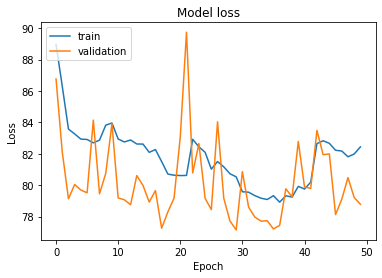

In [ ]:
plot_loss(history8)

In [ ]:
modelf = keras.models.Sequential()
modelf.add(keras.layers.Dense(12, input_shape=(12,)))
modelf.add(keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
modelf.add(keras.layers.Dense(12, activation='relu', kernel_initializer='normal'))
modelf.add(keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
modelf.add(keras.layers.Dense(4, activation='relu', kernel_initializer='normal'))
modelf.add(keras.layers.Dense(1, activation='linear'))
optimizer = keras.optimizers.RMSprop(lr=0.001)
modelf.compile(loss=['mape'], optimizer=optimizer)
  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
historyf = modelf.fit(xtrain, ytrain, epochs=50, batch_size=128, validation_split=0.25)

Epoch 1/50
4288/4288 [==============================] - 14s 3ms/step - loss: 98.8735 - val_loss: 98.8158
Epoch 2/50
4288/4288 [==============================] - 11s 3ms/step - loss: 98.8759 - val_loss: 98.8353
Epoch 3/50
4288/4288 [==============================] - 12s 3ms/step - loss: 98.8751 - val_loss: 98.9655
Epoch 4/50
4288/4288 [==============================] - 11s 3ms/step - loss: 98.8729 - val_loss: 98.8885
Epoch 5/50
4288/4288 [==============================] - 12s 3ms/step - loss: 98.8750 - val_loss: 98.8339
Epoch 6/50
4288/4288 [==============================] - 12s 3ms/step - loss: 98.8739 - val_loss: 98.8347
Epoch 7/50
4288/4288 [==============================] - 11s 3ms/step - loss: 98.8744 - val_loss: 98.8413
Epoch 8/50
4288/4288 [==============================] - 12s 3ms/step - loss: 98.8750 - val_loss: 98.8713
Epoch 9/50
4288/4288 [==============================] - 13s 3ms/step - loss: 98.8740 - val_loss: 98.8141
Epoch 10/50
4288/4288 [==============================] 

2.SGD

In [ ]:
model9 = keras.models.Sequential()
model9.add(keras.layers.Dense(12, input_shape=(12,)))
model9.add(keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
model9.add(keras.layers.Dense(12, activation='relu', kernel_initializer='normal'))
model9.add(keras.layers.Dense(8, activation='relu', kernel_initializer='normal'))
model9.add(keras.layers.Dense(4, activation='relu', kernel_initializer='normal'))
model9.add(keras.layers.Dense(1, activation='linear'))
model9.compile(loss=['mape'], optimizer=keras.optimizers.SGD(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history9 = model9.fit(xtrain, ytrain, epochs=50, batch_size=128, validation_split=0.25, shuffle=True)

Epoch 1/50
4288/4288 [==============================] - 13s 3ms/step - loss: 241.0502 - val_loss: 394.5087
Epoch 2/50
4288/4288 [==============================] - 11s 3ms/step - loss: 240.2315 - val_loss: 113.0532
Epoch 3/50
4288/4288 [==============================] - 10s 2ms/step - loss: 241.1143 - val_loss: 336.8488
Epoch 4/50
4288/4288 [==============================] - 10s 2ms/step - loss: 239.8948 - val_loss: 101.6484
Epoch 5/50
4288/4288 [==============================] - 11s 3ms/step - loss: 240.6165 - val_loss: 121.8579
Epoch 6/50
4288/4288 [==============================] - 11s 2ms/step - loss: 239.9169 - val_loss: 333.2682
Epoch 7/50
4288/4288 [==============================] - 10s 2ms/step - loss: 240.4420 - val_loss: 292.9426
Epoch 8/50
4288/4288 [==============================] - 11s 3ms/step - loss: 238.9080 - val_loss: 369.0178
Epoch 9/50
4288/4288 [==============================] - 11s 3ms/step - loss: 240.0726 - val_loss: 211.2673
Epoch 10/50
4288/4288 [==============

In [ ]:
calculate_error(model9, ytest)

Mean Absolute error 0.6153267770616914 
 Mean Squared error 0.981948188912607 
 Mean absolute percentage error 0.9996979670179065


(0.6153267770616914, 0.981948188912607, 0.9996979670179065)

dict_keys(['loss', 'val_loss'])


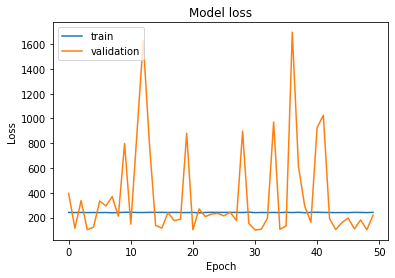

In [ ]:
plot_loss(history9)

In [ ]:
def best_model(optimizer=keras.optimizers.Adam(), activation='relu'):
  modell = keras.Sequential()
  modell.add(keras.layers.Dense(12, input_shape=(12,)))
  modell.add(keras.layers.Dense(16, activation=activation))
  modell.add(keras.layers.Dense(8, activation=activation))
  modell.add(keras.layers.Dense(4, activation=activation))
  modell.add(keras.layers.Dense(1, activation='linear'))
  modell.compile(optimizer=optimizer, loss=['mape'])
  return modell

In [ ]:
keras_gg = keras.wrappers.scikit_learn.KerasRegressor(best_model)
params = {'optimizer':[keras.optimizers.Adam(), keras.optimizers.RMSprop()], 'activation':['relu', 'sigmoid']}
rnd2 = RandomizedSearchCV(keras_gg, params, n_iter=5,
cv=3)
rnd2.fit(xtrain, ytrain, epochs=10,
validation_data=(xtest, ytest),
callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

In [ ]:
rnd2.best_params_

In [ ]:
new = rnd2.best_estimator_.model
new.summary()

In [ ]:
history_new = new.fit(xtrain, ytrain, epochs=100, validation_split=0.2, batch_size=128)

In [ ]:
calculate_error(new, ytest)

In [ ]:
plot_loss(history_new)

In [ ]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year,H_Distance
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,13,1,27,5,1,2015,2.323260
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,13,1,27,5,1,2015,2.425353
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,11,5,8,40,10,2011,0.618628
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,21,5,1,48,12,2012,1.961033
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,21,5,1,48,12,2012,5.387301


In [ ]:

test.shape()

In [ ]:
test_predic = new.predict(test)

In [ ]:
print(test_predic)

In [ ]:
original_test = scalery.inverse_transform(test_predic)
original_test

In [ ]:
test['fare_amount'] = original_test.flatten().tolist()
test.head()